# Recipe Recommendation System
Creating, Testing, and Tuning unsupervised learning methods to recommend relevant recipes based on ingredient and category preference

Workflow:
1. Load, aggregate, clean, and tokenize recipe text data
    - Identify Food Recipe Specific stop words that might be useful to ignore (e.g. measurements, numbers)
    - It's likely that recipe attributes will depend heavily on ingredients and cooking methods, not necessarily
    - Think twice about assigning words as stopwords, they might end up being useful.
    - You may want to lemmatize the data to reduce sparseness; check lemmatization process to see if it strips important words, foods, or ingredients. Also, remove punctuation: it won't help for keyword 
2. ~~Create Word Embeddings using Word2Vec or GloVe Models (Consider using pretrained word embeddings)~~
    - Discuss in detail the reason to choose one over the other for this context
    - Setup neural network locally and run remotely on google colab
    - I want to try tfidf and GloVe model, because tfidf doesn't take into account the order of words, which is isn't such a problem with recipes - it's the ingredients and cooking techniques that matter more. However, GloVe word vectors may be able to produce new words outside of the corpora text when summarizing the documents
3. Compare Topic Extraction Methods
    - ~~LDA2Vec~~
    - LDA
    - NNMF
4. Generate keywords using keyword summarization and textrank
    - Create methodology selectively assigns generated categories (e.g. LSA/NNMF Score must be above certain score threshold)
    - Define metrics that evaluate the validity, breadth, and descriptive value of the assigned categories
    - Identify Food Recipe Specific stop words that passed that might be suitable in the filter.
5. Create extra features useful for search result ranking
    - ~~Difficulty (Time, Number of Ingredients, Servings (inverse relationship),~~
    - Import Unsupervised Generated Categories
    - Create ratings that calculate overall weight.
6. Find similarity scoring methods that would work best in this context. Some variation of Cosine Similarity will work best
7. Create algorithm that utilizes similarity to sort recipes based on user-inputted queries, and sort base on other features as well.

-----

Regarding the Available Recipe Images

Around 70,000 recipes out of the 125,000 have corresponding images, so it's possible to utilize these images to improve the models or create seperate, supplementary model

Ideas:
- Training a neural network to identify/predict/generate categories of foods based on their images


### The Data
Although I can no longer find the direct download, the link and code for the scraper that from the user that collected the data set is [here](https://github.com/rtlee9/recipe-box). This user collecte title, ingredients, and instructions from recipes found on Allrecipes.com, epicurious.com, and foodnetwork.com.

The data was orginally directed downloaded and uploaded here for the creation of my own model. All code presented are all of my own creation or significantly modified from the Thinkful curriculum. No other software sources were used verbatim within this project.

In [1]:
import pandas as pd
import numpy as np
import re
import spacy

In [18]:
allrecipes_raw = pd.read_json('../__DATA__/recipes_raw/recipes_raw_nosource_ar.json')
epicurious_raw = pd.read_json('../__DATA__/recipes_raw/recipes_raw_nosource_epi.json')
foodnetwork_raw = pd.read_json('../__DATA__/recipes_raw/recipes_raw_nosource_fn.json')

In [132]:
allrecipes = allrecipes_raw.copy().T.reset_index().drop(columns = ['index'])
allrecipes.head(1)

,ingredients,instructions,picture_link,title
0,"[4 skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ...",55lznCYBbs2mT8BTx6BTkLhynGHzM.S,Slow Cooker Chicken and Dumplings


In [133]:
epicurious = epicurious_raw.copy().T.reset_index().drop(columns = ['index'])
epicurious.head(1)

,ingredients,instructions,picture_link,title
0,"[12 egg whites, 12 egg yolks, 1 1/2 cups sugar...","Beat the egg whites until stiff, gradually add...",None,Christmas Eggnog


In [134]:
foodnetwork = foodnetwork_raw.copy().T.reset_index().drop(columns = ['index'])
foodnetwork.head(1)

,ingredients,instructions,picture_link,title
0,"[1/2 cup celery, finely chopped, 1 small green...",Toss ingredients lightly and spoon into a butt...,None,Grammie Hamblet's Deviled Crab


In [135]:
recipes = pd.concat([allrecipes, epicurious, foodnetwork]).reset_index(drop=True) # Concat does not reset indices
recipes.shape

(125164, 4)

In [136]:
# Count of missing values by category
recipes.isna().sum()

ingredients       517
instructions      691
picture_link    42571
title             569
dtype: int64

In [137]:
# Number recipes/rows that have any missing values besides missing pictures
null_recs = recipes.copy().drop(columns = 'picture_link').T.isna().any()
null_recs.sum()

691

In [138]:
recipes[null_recs].head()

,ingredients,instructions,picture_link,title
5874,NaN,NaN,NaN,NaN
15020,NaN,NaN,NaN,NaN
15023,NaN,NaN,NaN,NaN
15025,NaN,NaN,NaN,NaN
15637,NaN,NaN,NaN,NaN


In [139]:
rows_to_drop = recipes[null_recs].index
recipes = recipes.drop(index = rows_to_drop).reset_index(drop = True)
recipes.shape

(124473, 4)

In [140]:
recipes.dtypes

ingredients     object
instructions    object
picture_link    object
title           object
dtype: object

In [141]:
# Indexing rows with columns that only contain numbers or punctuation
import string
nc_ingred_index = [index for i, index in zip(recipes['ingredients'], recipes.index) if all(j.isdigit() or j in string.punctuation for j in i)]
nc_title_index = [index for i, index in zip(recipes['title'], recipes.index) if all(j.isdigit() or j in string.punctuation for j in i)]
nc_instr_index = [index for i, index in zip(recipes['instructions'], recipes.index) if all(j.isdigit() or j in string.punctuation for j in i)]


In [142]:
# Checking number of rows in each category that are only punc/nums
index_list = [nc_ingred_index, nc_title_index, nc_instr_index]
[len(x) for x in index_list]

[1520, 0, 39]

In [143]:
# generating unique indices for index_list and dropping from dataframe
# recipes without recipe instructions or ingredients are not useable
from functools import reduce
from operator import add
inds_to_drop = set(reduce(add, index_list))
print(len(inds_to_drop))
recipes = recipes.drop(index=inds_to_drop).reset_index(drop=True)
recipes.shape

1551


(122922, 4)

In [146]:
# Recipe instructions with less than 20 characters are not good recipes
empty_instr_ind = [index for i, index in zip(recipes['instructions'], recipes.index) if len(i) < 20]
recipes = recipes.drop(index = empty_instr_ind).reset_index(drop=True)

In [147]:
recipes.shape

(122911, 4)

In [148]:
recipes.isna().sum()

ingredients         0
instructions        0
picture_link    41687
title               0
dtype: int64

In [159]:
# Checking for low ingredient recipes.
#low_ingr_ind = [index for i, index in zip(recipes['ingredients'], recipes.index) if len(i) < 20]
low_ingr_index = [index for i, index in zip(recipes['ingredients'], recipes.index) if i[0] == np.nan]
len(low_ingr_index)
recipes.loc[low_ingr_index, 'ingredients']

Series([], Name: ingredients, dtype: object)

In [155]:
# Searching for pseudo empty lists
[index for i, index in zip(recipes['ingredients'], recipes.index) if np.nan in recipes.loc[index,'ingredients']]


[]

### Cleaning to Prepare for Tokenizing

Cleaning Specifics:
- Removing ADVERTISEMENT
- Pruning dataset of rows with empty cells or inadequate recipes
- Remove all punctuation, digits, and extraneous spacing

In [196]:
# Removing ADVERTISEMENT text from ingredients list
ingredients = []
for ing_list in recipes['ingredients']:
    clean_ings = [ing.replace('ADVERTISEMENT','').strip() for ing in ing_list]
    if '' in clean_ings:
        clean_ings.remove('')
    ingredients.append(clean_ings)
recipes['ingredients'] = ingredients

In [199]:
recipes.loc[0,'ingredients']

['4 skinless, boneless chicken breast halves',
 '2 tablespoons butter',
 '2 (10.75 ounce) cans condensed cream of chicken soup',
 '1 onion, finely diced',
 '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces']

In [200]:
# Extracting ingredients from their lists and formatting as single strings
recipes['ingredient_text'] = ['; '.join(ingredients) for ingredients in recipes['ingredients']]
recipes['ingredient_text'].head()


0    4 skinless, boneless chicken breast halves; 2 ...
1    2 (10.75 ounce) cans condensed cream of mushro...
2    1/2 cup packed brown sugar; 1/2 cup ketchup; 1...
3    1 cup butter, softened; 1 cup white sugar; 1 c...
4    8 ounces whole wheat rotini pasta; 3 cups fres...
Name: ingredient_text, dtype: object

In [201]:
# Counting the number of ingredients used in each recipe
recipes['ingredient_count'] = [len(ingredients) for ingredients in recipes['ingredients']]

In [212]:
recipes.head(1)

,ingredients,instructions,picture_link,title,ingredient_text,ingredient_count
0,"[4 skinless, boneless chicken breast halves, 2...","Place the chicken, butter, soup, and onion in ...",55lznCYBbs2mT8BTx6BTkLhynGHzM.S,Slow Cooker Chicken and Dumplings,"4 skinless, boneless chicken breast halves; 2 ...",5


In [211]:
all_text = recipes['title'] + ' ' + recipes['ingredient_text'] + ' ' + recipes['instructions']
all_text[0]

'Slow Cooker Chicken and Dumplings 4 skinless, boneless chicken breast halves; 2 tablespoons butter; 2 (10.75 ounce) cans condensed cream of chicken soup; 1 onion, finely diced; 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n'

In [ ]:
# Clean_text Function
import string
import re

def clean_text(documents):
    cleaned_text = []
    for doc in documents:
        doc = doc.translate(str.maketrans('', '', string.punctuation)) # Remove Punctuation
        doc = re.sub(r'\d+', '', doc) # Remove Digits
        doc = doc.replace('\n',' ') # Remove New Lines
        doc = doc.strip() # Remove Leading White Space
        doc = re.sub(' +', ' ', doc) # Remove multiple white spaces
        cleaned_text.append(doc)
    return cleaned_text

# Cleaning Text
cleaned_text = clean_text(all_text)

In [228]:
cleaned_text[2]

'Brown Sugar Meatloaf cup packed brown sugar cup ketchup pounds lean ground beef cup milk eggs teaspoons salt teaspoon ground black pepper small onion chopped teaspoon ground ginger cup finely crushed saltine cracker crumbs Preheat oven to degrees F degrees C Lightly grease a x inch loaf pan Press the brown sugar in the bottom of the prepared loaf pan and spread the ketchup over the sugar In a mixing bowl mix thoroughly all remaining ingredients and shape into a loaf Place on top of the ketchup Bake in preheated oven for hour or until juices are clear'

### Tokenizing Using Spacy

For this tokenization, we will lemmatize the words. This is will help create a denser word embeddings. However, no POS tagging, know entities, or noun_phrases will be parsed and added.

In [230]:
# Testing Strategies and Code
nlp = spacy.load('en')

' '.join([token.lemma_ for token in nlp(cleaned_text[2]) if not token.is_stop])

'Brown Sugar Meatloaf cup pack brown sugar cup ketchup pound lean ground beef cup milk egg teaspoon salt teaspoon ground black pepper small onion chop teaspoon ground ginger cup finely crush saltine cracker crumb Preheat oven to degree F degree C lightly grease a x inch loaf pan Press the brown sugar in the bottom of the prepared loaf pan and spread the ketchup over the sugar in a mixing bowl mix thoroughly all remain ingredient and shape into a loaf Place on top of the ketchup Bake in preheat oven for hour or until juice be clear'

My current strategy is to strip down the text as much as possible. In this case that means lemmatizing words and removing stop words. The goal here is not text prediction, but similarity measures and keyword extraction, which don't require the semantic granularity that stop words and non-lemmatized words might provide.

In [231]:
# Tokenizing Function that lemmatizes words and removes Stop Words
def text_tokenizer(documents):
    tokenized_documents = []
    for doc in documents:
        tok_doc = ' '.join([token.lemma_ for token in nlp(doc) if not token.is_stop])
        tokenized_documents.append(tok_doc)
    return tokenized_documents

In [237]:
# Tokenizing Function to run in parallel
def text_tokenizer_mp(doc):
    tok_doc = ' '.join([token.lemma_ for token in nlp(doc) if not token.is_stop])
    return tok_doc

In [236]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  12


In [242]:
# Parallelzing tokenizing process
pool = mp.Pool(mp.cpu_count())
tokenized_text = pool.map(text_tokenizer_mp, [doc for doc in cleaned_text])

Process ForkPoolWorker-41:
Process ForkPoolWorker-42:
Process ForkPoolWorker-45:
Process ForkPoolWorker-46:
Process ForkPoolWorker-47:
Process ForkPoolWorker-39:
Process ForkPoolWorker-48:
Process ForkPoolWorker-43:
Process ForkPoolWorker-44:
Process ForkPoolWorker-38:
Process ForkPoolWorker-40:
Process ForkPoolWorker-37:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  

  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
KeyboardInterrupt
Keyboa

In [ ]:
# Save the tokenized_text variable as a csv in order to return to it;
# Do not attempt to run the parser above, it will simply take too long
# Reload the csv from file insted
pd.Series(tokenized_text).to_csv('tokenized_text.csv')

In [244]:
tokenized_text[0]

'Slow Cooker Chicken Dumplings skinless boneless chicken breast halve tablespoon butter ounce can condense cream chicken soup onion finely diced ounce package refrigerate biscuit dough tear piece Place chicken butter soup onion slow cooker fill water cover Cover cook hour high minute serve place torn biscuit dough slow cooker Cook dough longer raw center'

### Creating Word Embeddings

- TF-IDF
- Pre-trained GloVe Word Embeddings
- GloVe Embeddings trained on the recipe corpora

In an attempt to create dense word embeddings, I could find no reliable examples to follow that integrate GloVe or Word2Vec with document topic modeling.

In [251]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase = True,
                            ngram_range = (1,1))

text_tfidf = vectorizer.fit_transform(tokenized_text)
tfidf_words = vectorizer.get_feature_names()
print(text_tfidf.shape)
print(len(tfidf_words))

(122911, 49785)
49785


## Topic Modeling
- LDA
- NNMF

The ultimate goal with topic modeling is to group documents together and generate category words using TextRank. These category words can then be used to further refine the recommendation query

------

LDA and NNMF extract topic models by finding similar subgroups of text within the corpora of recipes (or other text documents). However

In [252]:
text_tfidf.shape

(122911, 49785)

In [253]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components = 50,
          n_jobs = -1,
          max_iter = 100)
text_lda = lda.fit_transform(text_tfidf)
text_lda.shape

(122911, 50)

In [254]:
from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0,
         init='nndsvdar',
         l1_ratio=0.0,
         max_iter = 100,
         n_components = 50,
         solver='cd')

text_nmf = nmf.fit_transform(text_tfidf)
text_nmf.shape

(122911, 50)

Models were arbitrarily set to 50 topics. Unfortunately, neither NNMF nor LDA have the ability to calculate the percentage of variance that they capture from the original tfidf matrix. So 50 topics is purely a shot in the dark.

Next Steps:
1. Document x Topic Matrix
2. Word x Topic Matrix

## Exploring Topics by Document

In [415]:
# variable dependencies:
text_series = pd.Series(all_text)

def docs_by_tops(top_mat, topic_range = (0,0), doc_range = (0,2)):
    for i in range(topic_range[0], topic_range[1]):
        topic_scores = pd.Series(top_mat[:,i])
        doc_index = topic_scores.sort_values(ascending = False)[doc_range[0]:doc_range[1]].index
        for j, index in enumerate(doc_index, doc_range[0]):
            print('Topic #{}'.format(i),
                  '\nDocument #{}'.format(j),
                  '\nTopic Score: {}\n\n'.format(topic_scores[index]),
                  text_series[index], '\n\n')

In [402]:
docs_by_tops(text_lda,(0,3),(0,3))

Topic #0 
Document #0 
Topic Score: 0.9123109709196908

 Greek Shrimp Salad 1/2 cup plain yogurt; 2 tablespoons fresh lemon juice; 2 tablespoons cucumber, peeled, seeded, and finely diced; 1 tablespoon minced red onion; 1 tablespoon minced fresh dill leaves; 1 teaspoon minced garlic; Pinch cayenne pepper; Kosher salt; Freshly ground black pepper; 1 romaine heart, torn into bite-size pieces; 4 cups mixed baby lettuces, washed and dried; 1/2 cup each red and yellow bell peppers, cored, seeded, trimmed, and cut into 1-inch cubes; 1/2 cup Caramelized Onions (recipe follows); 1/2 cup Kalamata olives, pitted; 1 small cucumber, peeled, seeded, quartered, cut into 1/2-inch slices; 1 cup yellow pear and Sweet 100 cherry tomatoes, cut in halves; 1/2 cup freshly grated Parmesan cheese; 1 cup crumbled feta cheese; 1 cup Greek Salad Dressing, recipe follows; Kosher salt; Freshly ground black pepper; 16 large shrimp, peeled, deveined, cut in half horizontally, blanched; 1/4 cup toasted pine nuts *; 

In [403]:
docs_by_tops(text_nmf,(0,3),(0,3))

Topic #0 
Document #0 
Topic Score: 0.03278719453831286

 Black Olive Spread 1 (10 ounce) can black olives; 3 tablespoons freshly grated Parmesan cheese; 1 clove garlic, chopped; 1 tablespoon extra virgin olive oil Place olives, Parmesan cheese, and garlic (if using) in a food processor. Add olive oil slowly while running. Process until smooth.
 


Topic #0 
Document #1 
Topic Score: 0.03139224917980079

 Pesto 3/4 cup fresh basil leaves; 1/2 cup grated Parmesan; 3 tablespoons pine nuts; 2 cloves garlic, peeled; Salt and freshly ground black pepper; 1/3 cup extra-virgin olive oil Watch how to make this recipe.
Add the basil leaves, Parmesan, pine nuts, garlic and salt and pepper to taste to a food processor or blender. Turn the machine on, then drizzle in the olive oil while it mixes. Continue blending until combined, adding additional olive oil if needed. 


Topic #0 
Document #2 
Topic Score: 0.03064833480260115

 Kalamata Olive Tapenade 3 cloves garlic, peeled; 1 cup pitted kalamata

In [423]:
docs_by_tops(text_nmf,(1,2),(90000,90001))

Topic #1 
Document #90000 
Topic Score: 0.0

 Grilled Hoisin Marinated Pork with Pineapple-Grilled Green Onion Relish 1/4 cup hoisin sauce; 2 tablespoons rice wine vinegar; 2 tablespoons soy sauce; 3 cloves garlic, coarsely chopped; 1 teaspoon sesame oil; 1 (2 pound) boneless pork tenderloin; Salt and freshly frond pepper Combine hoisin, vinegar, soy, garlic and sesame oil in a small bowl. Place the tenderloin in a medium shallow baking dish, pour over the marinade and marinate in the refrigerator 3 to 4 hours or overnight, turning once. Preheat the grill. Remove the pork from the marinade, removing any excess. Season with salt and pepper and grill 10 to 12 minutes for medium doneness. 




### Exploring Topics by words

In [302]:
text_nmf.shape

(122911, 50)

In [304]:
text_tfidf.T.shape

(49785, 122911)

In [321]:
# Function for best topic words using cosine similarity
# Variable Dependency:
word_series = pd.Series(tfidf_words)

def words_by_tops(tfidf_mat, top_mat, topic_range=(0,0), n_words=10):
    topic_word_scores = tfidf_mat.T * top_mat
    for i in range(topic_range[0],topic_range[1]):
        word_scores = pd.Series(topic_word_scores[:,i])
        word_index = word_scores.sort_values(ascending = False)[:n_words].index
        print('\nTopic #{}'.format(i))
        for index in word_index:
            print(word_series[index],'\t\t', word_scores[index])

In [322]:
# Keywords using LDA
words_by_tops(text_tfidf, text_lda, (0,3), 10)


Topic #0
oil 		 640.6245959649507
pepper 		 608.3249187745771
olive 		 596.4472242637255
salt 		 490.84989453469524
salad 		 455.8647473432865
cup 		 453.8848397846019
vinegar 		 433.1487240324012
tablespoon 		 404.63005650285976
lemon 		 358.3382905960618
tomato 		 347.0923702100207

Topic #1
pasta 		 778.6849751405178
add 		 535.0915861916765
pepper 		 492.7384925672631
cook 		 492.13785743221797
heat 		 483.2914698817875
cup 		 449.0481461754793
minute 		 431.5918368991962
oil 		 428.3394865493703
salt 		 412.09639996091306
garlic 		 398.4843344902204

Topic #2
cup 		 28.397756921546033
tablespoon 		 17.33665296790679
pepper 		 16.873417760793053
teaspoon 		 16.86288849893871
sugar 		 16.855922995406004
minute 		 16.812838373662142
salt 		 16.366286592989763
add 		 15.637303337055798
heat 		 15.55286683781459
oil 		 15.313294573959706


In [979]:
# Words using NMF
words_by_tops(text_tfidf, text_nmf, (0,3), 10)


Topic #0
oil 		 30.487976091510095
pepper 		 26.58731618077754
olive 		 25.976101984993985
garlic 		 21.15573358068711
salt 		 21.10278593840343
cup 		 19.11639414822675
tablespoon 		 18.92932664277406
add 		 16.703038528017764
heat 		 15.88131127232731
minute 		 15.717544839122644

Topic #1
cup 		 88.93948043725453
flour 		 78.21292584063856
sugar 		 74.87204294639442
egg 		 66.99731008186033
bake 		 62.46502324068086
teaspoon 		 56.665559229804835
butter 		 49.447980633147104
vanilla 		 44.3008418169541
degree 		 43.13128610977268
beat 		 38.99741959037972

Topic #2
chicken 		 121.53477084762409
breast 		 27.253496597768706
pepper 		 26.72384454656387
cup 		 25.717193394673707
heat 		 23.10877377789526
minute 		 22.93622161508001
cook 		 22.305917187923416
oil 		 21.817830898443503
tablespoon 		 20.985453149156356
sauce 		 19.748562716955515


Ultimately, in looking at the first three topic documents for LDA and NNMF, it appears that NNMF made more distinct topic models: 0. Spreads, 1. Cakes 2. Chicken.

LDA on the other made two good topics 0. Salads and 1. Gravies. The third topic, I am unable to tell what it's clustering on. Therefore, we will proceed with NNMF topics to generate

### Keyword Extraction of Topics Using TextRank

The purpose of using TextRank to extract keywords 

------------

Consider using a smaller corpora size, so as to more quickly code. Then run the entire copora.
Using the time module to test out corpora sizes.

Using TextRank to summarize the topics by extracting words involves many variables:
- Deciding how many of the top documents each the topic should be summarized?
    - Arbitrarily: top 100, evaluate, then only decrease from there.
- Should TextRank then be performed once over the selected topic corpora, or should it be run individually and then scores added to make an aggregated rank?
    - For the sake of simplicity it should probably only be run over the entire corpora
- How many top ranked words should be used?
    - Check out the top ranks words first, then decide.
    - Arbitrarily choosing the top 20 ranked
- Then once keywords are decided, to how many documents should those words be assigned the extract?
    - I think it depends on the number of documents used to find the categorical keywords.
- Once we're satisfied with a TextRank strategy, we need to this about which method to use to extract topics (NNMF, LDA) as well as whether we'll NNMF, LDA, or TextRank to extract keywords.

In [584]:
# Pulling the top one-hundred documents ranked in similarity among Topic #1
text_index = pd.Series(text_nmf[:,1]).sort_values(ascending = False)[:100].index
text_4summary = pd.Series(cleaned_text)[text_index]

# Manually Creating a list of recipe stop
recipe_stopwords = ['cup','cups','ingredient','ingredients','teaspoon','tablespoon','oven']


Because recipes are a very niche subject matter within NLP, it's likely that there are no list of stopwords related to this domain. The above 'recipe_stopwords' will thus be manually updated as necessary.

In [585]:
# generating topic filter
import time
start_time = time.time()

parsed_texts = nlp(' '.join(text_4summary)) 
kw_filts = set([str(word) for word in parsed_texts 
                if (word.pos_== ('NOUN' or 'ADJ' or 'VERB'))
                and str(word) not in recipe_stopwords])

print('Execution Time: {} seconds', time.time() - start_time)


Execution Time: {} seconds 1.5144927501678467


In [586]:
# Creating adjecency Table for recipes.
adjacency = pd.DataFrame(columns=kw_filts, index=kw_filts, data = 0)
for i, word in enumerate(parsed_texts):
    if any ([str(word) == item for item in kw_filts]):
        end = min(len(parsed_texts), i+5) # Window of four words
        nextwords = parsed_texts[i+1:end]
        inset = [str(x) in kw_filts for x in nextwords]
        neighbors = [str(nextwords[i]) for i in range(len(nextwords)) if inset[i]]
        if neighbors:
            adjacency.loc[str(word), neighbors] += 1

For the sake of implementing a simple TextRank precedure, all of the recipes were concatenated into one continuous corpora. The issue with this is that in tabulating the word adjacencies there is no delineation between one recipe and the next. So the neighbors at the tail ends of any one recipe are considered neighbors to the words at the front end of the next corresponding recipe. However, while this does generate false word adjacencies, the recipes are ordered by topic rank so that that adjacent recipes are in content. In theory, this dampens the effect, if any, that the false word adjacencies might create.

247

In [587]:
import networkx as nx

# Running TextRank
nx_words = nx.from_numpy_matrix(adjacency.values)
ranks=nx.pagerank(nx_words, alpha=.85, tol=.00000001)

# Identifying the most highly ranked keywords
ranked = sorted(((ranks[i],s) for i,s in enumerate(kw_filts)),
                reverse=True)

In [591]:
ranked[:25]

[(0.04375214185749701, 'baking'),
 (0.04062164866585882, 'flour'),
 (0.034765682332723105, 'degrees'),
 (0.03310625480601449, 'sugar'),
 (0.026319873865575237, 'salt'),
 (0.025259351906364934, 'powder'),
 (0.024942804418220832, 'C'),
 (0.02491387919033362, 'vanilla'),
 (0.022548613569828516, 'soda'),
 (0.021656675119152743, 'mixture'),
 (0.02009304199254083, 'bowl'),
 (0.019563092603302832, 'eggs'),
 (0.01947066454528181, 'Grease'),
 (0.017033128335097448, 'batter'),
 (0.016192349971297367, 'cinnamon'),
 (0.015994041246240872, 'pan'),
 (0.01598697844748971, 'F'),
 (0.015937798910130623, 'teaspoons'),
 (0.015466745614804127, 'egg'),
 (0.014890797265750865, 'extract'),
 (0.014635208820621701, 'butter'),
 (0.012583338619568181, 'oil'),
 (0.012564662523702128, 'ground'),
 (0.011802096339683934, 'minutes'),
 (0.011555344795180309, 'muffin')]

In [576]:
adjacency.shape

(247, 247)

In [578]:
# checking to see there are actual values loaded in the adjacency df
import scipy
scipy.sparse.csr_matrix(adjacency.copy().values)

<247x247 sparse matrix of type '<class 'numpy.int64'>'
	with 2497 stored elements in Compressed Sparse Row format>

Looking just at the top ranked keywords for the Topic \#1 documents, one would guess that the topic that was clustered is baked cakes. The top ranked word is 'baking' which is spot on! Unfortunately, because we used tf-idf, there is no way of calculating from these keywords a sort of categorical vector mapping such as 'baking'. If we were to use some sort of word embeddings such as Word2Vec or GloVe then we might be able to calculate abstract summaries of these words.

However, these keyword extractions are still useful insofar that the queries will match indidrectly to the the umbrella topic of 'baking' if those queries still match with the words extracted from the baking topic.

For now, we will arbitratily choose between text rank and nnmf word topic ranks to generate keywords. TextRank is a clear winner over mere text cosine similarity ranks in the case of this topic, so we will proceed with using TextRank as the categories. 

In [579]:
len(kw_filts)

247

In [581]:
pd.Series(list(kw_filts)).nunique()

247

In [397]:
text_4summary[3060]

'Blueberry Buttermilk Coffeecake cup butter cups white sugar eggs teaspoon vanilla extract cups buttermilk cups allpurpose flour teaspoons baking powder teaspoon baking soda teaspoon salt cups blueberries cup allpurpose flour cup white sugar tablespoons butter softened Preheat oven to degrees F degrees C Grease and flour a x inch pan Sift together cups flour baking powder baking soda and salt Set aside In a large bowl cream together cup butter and cup sugar until light and fluffy Beat in the eggs one at a time then stir in the vanilla Beat in the flour mixture alternately with the buttermilk mixing just until incorporated Sir in blueberries Pour batter into prepared pan In a small bowl combine cup flour and cup sugar cut in tablespoons butter until mixture resembles coarse crumbs Sprinkle over top of batter Bake in the preheated oven for to minutes or until a toothpick inserted into the center of the cake comes out clean Allow to cool'

Exploration of TextRank Takeaways: 
- All of the filter keyword are pretty similar because they were all extracted from the top 100 recipes within their topic.
- Recipes NLP stopwords need to be compiled
- The keywords that TextRank extracts relate really well to the underlying extracted topic, however, there's no way of abstractively generating semantically similar words that collectively captures the essence of the topic
- False adjacencies are created but the produced keywords do not look dissimilar from the topic modelled words using NNMF.
- One downside of using TextRank is that upon inspection of the ranked words and the filter words, it appears multiple copies of the same words are not getting identified as unique, such that, for example, there will be multiple copies of 'toothpick' or 'cups' with different individual rankings.



### Analyzing Score distribution of document and word ranks within Topics
The purpose is to visualize the distribution of document topic rankings and decide the cutoff for the documents that associate most with that topic.

In [429]:
import matplotlib.pyplot as plt
# text_lda
# text_nmf
# ranked

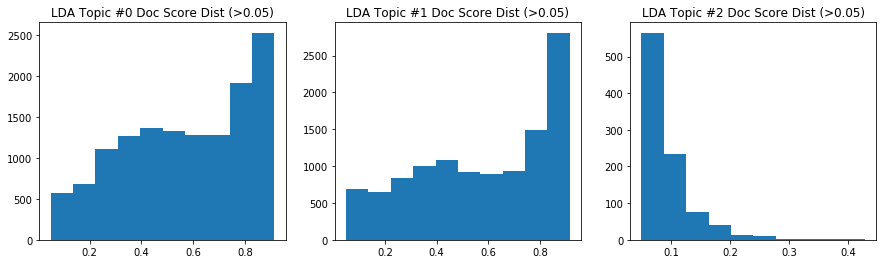

In [456]:
# LDA Topic documents for topics 0-2
plt.figure(figsize=(15,4))
for i in range(3):
    series = pd.Series(text_lda[:,i])
    plt.subplot(1,3,i+1)
    plt.hist(series[series > 0.05])
    plt.title('LDA Topic #{} Doc Score Dist (>0.05)'.format(i))
plt.show()

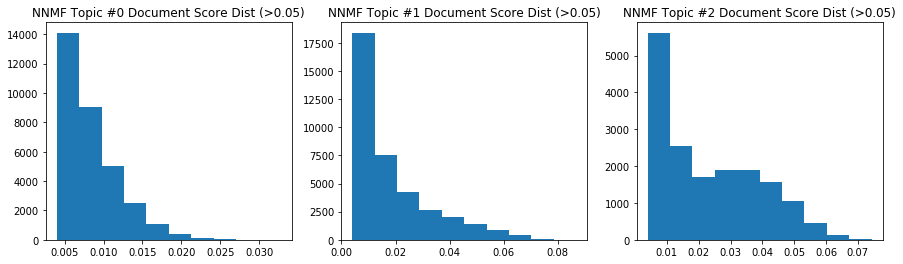

In [442]:
# NNMF Topic documents for topics 0-2
plt.figure(figsize=(15,4))
for i in range(3):
    series = pd.Series(text_nmf[:,i])
    plt.subplot(1,3,i+1)
    plt.hist(series[series > 0.004])
    plt.title('NNMF Topic #{} Document Score Dist (>0.004)'.format(i))
plt.show()

Based on the first three topics for LDA and NNMF, I will subjectly choose the top 1500-2000 documents. This number of documents seems to be where the loadings for each score distibution either level off or spike upward (an elbow so to speak).

Confirming with Topic \#1 of the NNMF topics, the baking topic, baking recipes extended as far as 10,000 of the top ranked recipes within that category.

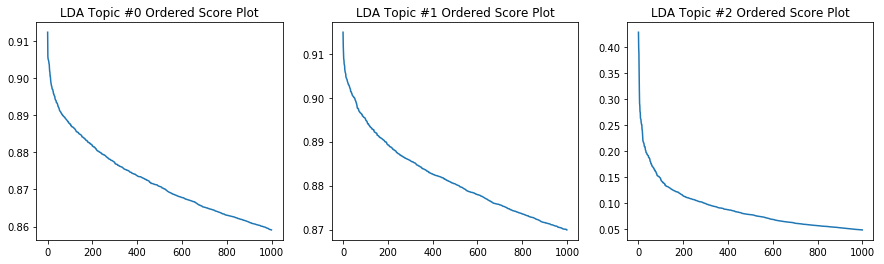

In [462]:
# LDA Topic document scores for topics 0-2
plt.figure(figsize=(15,4))
for i in range(3):
    series = pd.Series(text_lda[:,i]).copy().sort_values(ascending = False).reset_index(drop = True)
    plt.subplot(1,3,i+1)
    plt.plot(series[:1000])
    plt.title('LDA Topic #{} Ordered Score Plot'.format(i))
plt.show()

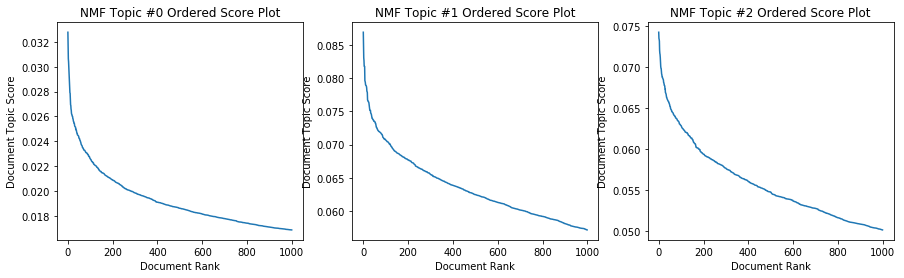

In [464]:
# NMF Topic document scores for topics 0-2
plt.figure(figsize=(15,4))
for i in range(3):
    series = pd.Series(text_nmf[:,i]).copy().sort_values(ascending = False).reset_index(drop = True)
    plt.subplot(1,3,i+1)
    plt.plot(series[:1000])
    plt.title('NMF Topic #{} Ordered Score Plot'.format(i))
    plt.xlabel('Document Rank')
    plt.ylabel('Document Topic Score')
plt.show()

While this method has not been previously utilized, the plots above take  after scree plots, and they plot the scores of documents as they relate to their respective topics in descending order. By plotting these elbow plots, it might shed light on the best number of documents to use to rank words.

We will be using NNMF for the model because the topics seemed to have converged more distinctly on topic. According to the 'Scree Plots' corresponding to the NNMF topics, it seems that the scores begin leveling out around 200 documents. Therefore we will use TextRank on the top 200 documents for each topic.

***One Note: Go deeper into depth why you chose NNMF over LDA.***

# \~~Putting it all together~~

Reintialize the model with 'pseudo-optimized' parameters, more easily track flow of data, and toggle with parameters all in one place. The "database" will also be created so that user queries will return results in a speedy manner!

Some pieces of code will be commented out with a triple ***\''' '''*** to indicate that the code takes too long to run and should only be run when the kernel has been shutdown.

In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
from functools import reduce
from operator import add
import string
import re
import multiprocessing as mp

### Below is all the necessary code necessary to clean the data into useable form for modeling.
'''
# Loading Data
allrecipes_raw = pd.read_json('../__DATA__/recipes_raw/recipes_raw_nosource_ar.json')
epicurious_raw = pd.read_json('../__DATA__/recipes_raw/recipes_raw_nosource_epi.json')
foodnetwork_raw = pd.read_json('../__DATA__/recipes_raw/recipes_raw_nosource_fn.json')

allrecipes = allrecipes_raw.copy().T.reset_index().drop(columns = ['index'])
epicurious = epicurious_raw.copy().T.reset_index().drop(columns = ['index'])
foodnetwork = foodnetwork_raw.copy().T.reset_index().drop(columns = ['index'])
recipes = pd.concat([allrecipes, epicurious, foodnetwork]).reset_index(drop=True) # Concat does not reset indices

# Cleaning
null_recs = recipes.copy().drop(columns = 'picture_link').T.isna().any()
rows_to_drop = recipes[null_recs].index
recipes = recipes.drop(index = rows_to_drop).reset_index(drop = True)

nc_ingred_index = [index for i, index in zip(recipes['ingredients'], recipes.index) if all(j.isdigit() or j in string.punctuation for j in i)]
nc_title_index = [index for i, index in zip(recipes['title'], recipes.index) if all(j.isdigit() or j in string.punctuation for j in i)]
nc_instr_index = [index for i, index in zip(recipes['instructions'], recipes.index) if all(j.isdigit() or j in string.punctuation for j in i)]

index_list = [nc_ingred_index, nc_title_index, nc_instr_index]

inds_to_drop = set(reduce(add, index_list))
print(len(inds_to_drop))
recipes = recipes.drop(index=inds_to_drop).reset_index(drop=True)
recipes.shape

empty_instr_ind = [index for i, index in zip(recipes['instructions'], recipes.index) if len(i) < 20]
recipes = recipes.drop(index = empty_instr_ind).reset_index(drop=True)

ingredients = []
for ing_list in recipes['ingredients']:
    clean_ings = [ing.replace('ADVERTISEMENT','').strip() for ing in ing_list]
    if '' in clean_ings:
        clean_ings.remove('')
    ingredients.append(clean_ings)
recipes['ingredients'] = ingredients

recipes['ingredient_text'] = ['; '.join(ingredients) for ingredients in recipes['ingredients']]
recipes['ingredient_text'].head()

recipes['ingredient_count'] = [len(ingredients) for ingredients in recipes['ingredients']]

all_text = recipes['title'] + ' ' + recipes['ingredient_text'] + ' ' + recipes['instructions']

def clean_text(documents):
    cleaned_text = []
    for doc in documents:
        doc = doc.translate(str.maketrans('', '', string.punctuation)) # Remove Punctuation
        doc = re.sub(r'\d+', '', doc) # Remove Digits
        doc = doc.replace('\n',' ') # Remove New Lines
        doc = doc.strip() # Remove Leading White Space
        doc = re.sub(' +', ' ', doc) # Remove multiple white spaces
        cleaned_text.append(doc)
    return cleaned_text

cleaned_text = clean_text(all_text)

# Testing Strategies and Code
nlp = spacy.load('en')
' '.join([token.lemma_ for token in nlp(cleaned_text[2]) if not token.is_stop])

def text_tokenizer_mp(doc):
    tok_doc = ' '.join([token.lemma_ for token in nlp(doc) if not token.is_stop])
    return tok_doc

# Parallelzing tokenizing process
pool = mp.Pool(mp.cpu_count())
tokenized_text = pool.map(text_tokenizer_mp, [doc for doc in cleaned_text])
'''

# Creating TF-IDF Matrices and recalling text dependencies

'''import text_tokenized.csv here to'''

# TF-IDF vectorizer instance
'''vectorizer = TfidfVectorizer(lowercase = True,
                            ngram_range = (1,1))'''

'''text_tfidf = vectorizer.fit_transform(tokenized_text)'''

In [514]:
# Set All Recommendation Model Parameters
N_topics = 50             # Number of Topics to Extract from corpora
N_top_docs = 200          # Number of top documents within each topic to extract keywords
N_top_words = 25          # Number of keywords to extract from each topic
N_docs_categorized = 2000 # Number of top documents within each topic to tag 
N_neighbor_window = 4     # Length of word-radius that defines the neighborhood for
                          # each word in the TextRank adjacency table

# Query Similarity Weights
w_title = 0.2
w_text = 0.3
w_categories = 0.5
w_array = np.array([w_title, w_text, w_categories])

# Recipe Stopwords: for any high volume food recipe terminology that doesn't contribute
# to the searchability of a recipe. This list must be manually created.
recipe_stopwords = ['cup','cups','ingredient','ingredients','teaspoon','teaspoons','tablespoon',
                   'tablespoons','C','F']

In [515]:
# Renaming Data Dependencies
topic_transformed_matrix = text_nmf
root_text_data = cleaned_text

### Generating  tags (keywords/categories) and assigning to corresponding documents

In [623]:
from itertools import repeat

#recipes['tag_list'] = [[] for i in repeat(None, recipes.shape[0])]

def topic_docs_4kwsummary(topic_document_scores, root_text_data):
    text_index = pd.Series(topic_document_scores).sort_values(ascending = False)[:N_top_docs].index
    text_4kwsummary = pd.Series(root_text_data)[text_index]
    return text_4kwsummary

def generate_filter_kws(text_list):
    parsed_texts = nlp(' '.join(text_list)) 
    kw_filts = set([str(word) for word in parsed_texts 
                if (word.pos_== ('NOUN' or 'ADJ' or 'VERB'))
                and word.lemma_ not in recipe_stopwords])
    return list(kw_filts), parsed_texts

def generate_adjacency(kw_filts, parsed_texts):
    # Creating adjecency Table for recipes.
    adjacency = pd.DataFrame(columns=kw_filts, index=kw_filts, data = 0)
    for i, word in enumerate(parsed_texts):
        if any ([str(word) == item for item in kw_filts]):
            end = min(len(parsed_texts), i+N_neighbor_window+1) # Set neighborhood window here
            nextwords = parsed_texts[i+1:end]
            inset = [str(x) in kw_filts for x in nextwords]
            neighbors = [str(nextwords[i]) for i in range(len(nextwords)) if inset[i]]
            if neighbors:
                adjacency.loc[str(word), neighbors] += 1
    return adjacency
                
def generate_wordranks(adjacency):
    # Running TextRank
    nx_words = nx.from_numpy_matrix(adjacency.values)
    ranks=nx.pagerank(nx_words, alpha=.85, tol=.00000001)
    return ranks

def generate_tag_list(ranks):
    rank_values = [i for i in ranks.values()]
    ranked = pd.DataFrame(zip(rank_values, list(kw_filts))).sort_values(by=0,axis=0,ascending=False)
    kw_list = ranked.iloc[:N_top_words,1].to_list()
    return kw_list

# Master Function utilizing all above functions
def generate_tags(topic_document_scores, root_text_data):
    text_4kwsummary = topic_docs_4kwsummary(topic_document_scores, root_text_data)
    kw_filts, parsed_texts = generate_filter_kws(text_4kwsummary)
    adjacency = generate_adjacency(kw_filts, parsed_texts)
    ranks = generate_wordranks(adjacency)
    kw_list = generate_tag_list(ranks)
    return kw_list

def generate_kw_index(topic_document_scores):
    kw_index = pd.Series(topic_document_scores).sort_values(ascending = False)[:N_docs_categorized].index
    return kw_index

    

In [624]:
# Generating Tags and distributing to relevant documents
for i in range(topic_transformed_matrix.shape[1]):
    scores = topic_transformed_matrix[:,i]
    topic_kws = generate_tags(scores, root_text_data)
    kw_index_4df = generate_kw_index(scores)
    recipes.loc[kw_index_4df, 'tag_list'] += topic_kws
    if i%10 == 0:
        print('Topic #{} Checkpoint'.format(i))
print('done!')

Topic #0 Checkpoint
Topic #10 Checkpoint
Topic #20 Checkpoint
Topic #30 Checkpoint
Topic #40 Checkpoint
done!


In [626]:
# Saving the precious dataframe so that I never have to calculate that again.
recipes.to_csv('tagged_recipes_df.csv')

In [617]:
scores = topic_transformed_matrix[:,1]
topic_kws = generate_tags(scores, root_text_data)
kw_index_4df = generate_kw_index(scores)
recipes.loc[kw_index_4df, 'tag_list'] += topic_kws

In [726]:
recipes.loc[:5,'tag_list']

0                                                   []
1    [Measure, nutmeg, drop, raisin, remainder, sug...
2                                                   []
3    [sugar, degrees, flour, vanilla, baking, C, bo...
4    [remove, Measure, Drop, pack, cinnamon, Craisi...
5    [applesauce, looks, minutes, crumbs, bananas, ...
Name: tag_list, dtype: object

In [727]:
# Concatenating lists of tags into a string a collective of tags for each documents
recipes['tags'] = [' '.join(tags) for tags in recipes['tag_list']]

In [729]:
recipes.loc[:5,'tags']

0                                                     
1    Measure nutmeg drop raisin remainder sugar fla...
2                                                     
3    sugar degrees flour vanilla baking C bowl salt...
4    remove Measure Drop pack cinnamon Craisins pas...
5    applesauce looks minutes crumbs bananas add pu...
Name: tags, dtype: object

### Querying Algorithm
The final product presented is a search algorithm that takes in a list of ingredients or categories, and uses the query to return relavant recipes that utilize those ingredients or are similarly related to other ingredients and those recipes.

In [730]:
recipes.columns

Index(['ingredients', 'instructions', 'picture_link', 'title',
       'ingredient_text', 'ingredient_count', 'tag_list', 'tags'],
      dtype='object')

In [973]:
# Creating TF-IDF Matrices and recalling text dependencies

'''import text_tokenized.csv here to'''

# TF-IDF vectorizer instance
'''vectorizer = TfidfVectorizer(lowercase = True,
                            ngram_range = (1,1))'''

'''text_tfidf = vectorizer.fit_transform(tokenized_text)'''
#title_tfidf = vectorizer.transform(recipes['title'])
# text_tfidf    <== Variable with recipe ingredients and instructions
#tags_tfidf = vectorizer.transform(recipes['tags'])
# recipes   <== DataFrame; For indexing and printing recipes

# Query Similarity Weights
w_title = 0
w_text = 0
w_categories = 1


In [908]:
def qweight_array(query_length, qw_array = [1]):
    if query_length > 1:
        to_split = qw_array.pop()
        split = to_split/2
        qw_array.extend([split, split])
        return qweight_array(query_length - 1, qw_array)
    else:
        return np.array(qw_array)

def ranked_query(query):
    query = [[q] for q in query]      # place words in seperate documents
    q_vecs = [vectorizer.transform(q) for q in query] 
    qw_array = qweight_array(len(query),[1])
    q_weighted_vecs = q_vecs * qw_array
    q_final_vector = reduce(np.add,q_weighted_vecs)
    return q_final_vector

def overall_scores(query_vector):
    final_scores = title_tfidf*query_vector.T*w_title
    final_scores += text_tfidf*query_vector.T*w_text
    final_scores += tags_tfidf*query_vector.T*w_categories
    return final_scores

def print_recipes(index, query, recipe_range):
    print('Search Query: {}\n'.format(query))
    for i, index in enumerate(index, recipe_range[0]):
        print('Recipe Rank: {}\t'.format(i+1),recipes.loc[index, 'title'],'\n')
        print('Ingredients:\n{}\n '.format(recipes.loc[index, 'ingredient_text']))
        print('Instructions:\n{}\n'.format(recipes.loc[index, 'instructions']))
        
def Search_Recipes(query, query_ranked=False, recipe_range=(0,3)):
    if query_ranked == True:
        q_vector = ranked_query(query)
    else:
        q_vector = vectorizer.transform([' '.join(query)])
    recipe_scores = overall_scores(q_vector)
    sorted_index = pd.Series(recipe_scores.toarray().T[0]).sort_values(ascending = False)[recipe_range[0]:recipe_range[1]].index
    return print_recipes(sorted_index, query, recipe_range)
    

In [971]:
query = ['cream', 'banana', 'cinnamon']
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

Search Query: ['cream', 'banana', 'cinnamon']

Recipe Rank: 0	 Jumbo Fluffy Walnut Apple Muffins 

Ingredients:
1/2 cup butter; 1 1/4 cups white sugar; 1 teaspoon vanilla extract; 1/2 teaspoon salt; 2 eggs; 1 3/4 cups all-purpose flour; 2 teaspoons baking powder; 1/2 teaspoon ground cinnamon; 1/2 cup milk; 2 cups peeled, cored and sliced apples; 1/2 cup walnuts; 1/4 cup white sugar; 1/2 teaspoon ground cinnamon; 3 tablespoons all-purpose flour; 2 tablespoons butter, cubed
 
Instructions:
Preheat oven to 375 degrees F (190 degrees C). Coat top and insides of jumbo muffin pan with cooking spray, or line with muffin papers.
In a large bowl, cream together 1/2 cup butter, 1 1/4 cups sugar, vanilla, and salt until light and fluffy. Beat in eggs, one at time. Mix together the 1 3/4 cups of flour, baking powder, and 1/2 teaspoon cinnamon. Stir in the flour mixture alternately with the milk, mixing just until incorporated. Fold in apples and walnuts. Scoop into muffin cups to fill 3/4 full. Li

In [970]:
query = ['lemon','miso']
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

Search Query: ['lemon', 'miso']

Recipe Rank: 0	 Miso Butter with Chives 

Ingredients:
1/4 cup unsalted butter, softened; 2 tablespoons white miso paste; 1 tablespoon minced chives
 
Instructions:
Mash butter and miso paste together in a small bowl until smooth. Add chives; stir until incorporated. Cover with plastic wrap and chill until firm.


Recipe Rank: 1	 Nobu's Miso Soup 

Ingredients:
5 cups dashi; 1/3 cup white miso; Thinly sliced firm tofu and scallions
 
Instructions:
In a saucepan, heat dashi over low heat. Place miso in a fine strainer, and place the strainer in dashi. Using a whisk, gently push miso through strainer. Cook until heated through. Place tofu slices in soup, and cook until they rise to the top, about 1 minute. Add scallions to soup bowls, and ladle soup over. Serve immediately;

Recipe Rank: 2	 Miso Soup with Shiitake Mushrooms 

Ingredients:
4 cups vegetable broth; 4 shiitake mushrooms, thinly sliced; 1/4 cup miso paste; 4 teaspoons soy sauce; 1/3 cup diced 

In [978]:
query = ['blueberry', 'apple']
Search_Recipes(query, query_ranked=True, recipe_range=(0,3))

Search Query: ['blueberry', 'apple']

Recipe Rank: 0	 Orange-Honey Glazed Carrots 

Ingredients:
3 bunches carrots, peeled; 2 tablespoons unsalted butter; 2 tablespoons honey; Kosher salt; 1 teaspoon minced fresh ginger; 1 teaspoon grated orange zest; 1/2 cup freshly squeezed orange juice; 1/2 teaspoon freshly ground black pepper
 
Instructions:
Cut the carrots diagonally in 1-inch-thick slices. You should have about 5 cups of carrots. Place 1/2 cup water, the butter, honey, 2 teaspoons of salt, and the ginger in a large saute pan and bring to a boil. Add the carrots, cover the pan, and simmer over medium-low heat for 5 minutes. Remove the lid and continue to cook for about 20 minutes, or until all the water has evaporated. You may want to raise the heat for the last 5 minutes.
Add the orange zest and orange juice to the pan, tossing with the carrots. Simmer uncovered for about 5 minutes, until the carrots are al dente (tender but still resistant when you bite) and the sauce glazes the

### -- Conclusions and Model Outlook --

Overall the Search_Recipes function works quite well. From experimenting with the weighting, it's clear to me that the original text of the recipes returns better results than the categories generated with TextRank. More topics need to be added; from looking at the food topic documents, it's clear that the level of granularity with which LDA and NNMF can cluster recipe is very good. Another fix for this issue is to utilize dense word embeddings that capture semantic similarities between words with more sophistication. THe biggest issue with the current model is that the words that maps to each topics or category are limited and discreet. Even if a a words is technically more related to a topic than the words extracted from the same topic, yet the word was not extracted from the topic, then the original word query won't be factored into the search through the categories.

Also it does appear that some words are more heavily weighted than others, which biases the search results towards that ingredient, although this does require more rigorous texting. "Miso" is a word that is heavily weighted in the tfidf matrices for example. One work around is to use simple rank this ingredient lower in the Search_Recipes function, but a global solution is preferable. It is perhaps more beneficial to utilize these weights that tf-idf creates, rather than finding a way to get rid of them. But experimenting with different word embeddings would be interesting.

Also, another issue is that many recipes were not assigned categories due to the model parameters, and this decreases there ranks with the text with an unfair disadvantage. Hopefully a future iteration of this model will allow all recipes to have associated categories.

Future Implementation and Changes for this model:

- Word2Vec or GloVe embeddings
- LDA2Vec topic extraction
- Negative Querying that decreases rank of matching queries
- Using real databases to store data and creating a creating an user interface on which this model where this model can be easily utilized

